#Yolov4 (darknet) 自定義資料集訓練及推論範例  
歐尼克斯實境互動工作室 OmniXRI Jack, 2021.5.19 

注意：Google Colab有使用時間限制，原則上最長12小時，但經常會遇到數小時就會不正常斷線。另外若使用過久且一直在訓練階段，則有可能發生不能再使用GPU訊息產生，要一到數日後才會解鎖，要特別留意。

參考來源：https://github.com/AlexeyAB/darknet  
如何訓練自定義物件：https://github.com/AlexeyAB/darknet#how-to-train-to-detect-your-custom-objects

#1. 驗證Nvidia GPU及CUDA版本
確認運行環境（本步驟可略過）  
GPU每次配置可能不同，可能為 K80, T4, P100，記憶體大小可能會影響到後續訓練時Patch Size大小。  
若想要好一點的GPU則重覆斷開連線(Ctrl+M)再重新連線，直到出現期望的GPU出現，再進行下一個步驟。  

In [1]:
!nvidia-smi
!/usr/local/cuda/bin/nvcc --version

Tue May 18 15:43:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#2. 連接Google Drvie
建立捷徑 /my_drive 指向已掛載之Google Drvie (/content/drive/MyDrive/)  

In [2]:
from google.colab import drive

drive.mount('/content/drive')

!ln -s /content/drive/MyDrive/ /my_drive

Mounted at /content/drive


#3. 上傳預訓練檔及資料集到Google Drive
若已完成下列步驟，下次重新運行程式時本步驟可忽略不執行。 
1.   手動在Google Drive上建立一個 yolov4 檔案夾。  
2.   從 https://github.com/AlexeyAB/Darknet#pre-trained-models 下載 yolov4.weight(252MB)預訓練檔到自己的電腦。
3.   將 yolov4.weight 上傳到Google Drive的 yolov4 檔案夾中。  

若想訓練自定義物件，則需將自定義資料集及相關組態檔上傳到 yolov4 檔案夾中，包含下列六種檔案。更完整檔案修正方式請參考步驟8。  
1.   obj.data （物件資料設定）
2.   obj.names （物件類別名稱）
3.   yolov4.cfg （設定模型組態）
4.   train.txt （訓練內容，另含原始影像檔案壓縮檔）
5.   valid.txt （驗證內容，另含原始影像檔案壓縮檔）
6.   pre-trained.weight （從 https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137 下載預訓練檔）  


In [3]:
!ls /my_drive/yolov4

my_dataset.zip	my_obj.names  my_train.txt	    yolov4.conv.137
my_obj.data	my_test.txt   my_yolov4_custom.cfg  yolov4.weights


#4. 下載Yolov4 (darknet)

In [4]:
!git clone https://github.com/AlexeyAB/darknet
!ls

Cloning into 'darknet'...
remote: Enumerating objects: 15043, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 15043 (delta 14), reused 24 (delta 10), pack-reused 15002
Receiving objects: 100% (15043/15043), 13.47 MiB | 9.89 MiB/s, done.
Resolving deltas: 100% (10213/10213), done.
darknet  drive	sample_data


#5. 修改Makefile參數
將GPU, CUDNN, CUDNN_HALF, OPENCV設為可用  
GPU=0 --> GPU=1  
CUDNN=0 --> CUDNN=1  
CUDNN_HALF=0 --> CUDNN_HALF=1  
OPENCV=0 --> OPENCV=1

In [5]:
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

/content/darknet


#6. 編譯darknet

In [6]:
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:935:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1136:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
  

#7. 測試darknet編譯結果
1.   檢查目前工作路徑是否在 darknet 路徑
2.   執行darknet物件偵測推論，指定 data, config, weight, image 所在位置(darknet/data/ 路徑下有幾張jpg影像可供測試)。
3.   顯示結果影像predictions.jpg

3rdparty	DarknetConfig.cmake.in	json_mjpeg_streams.sh  results
backup		darknet_images.py	LICENSE		       scripts
build		darknet.py		Makefile	       src
build.ps1	darknet_video.py	net_cam_v3.sh	       vcpkg.json
cfg		data			net_cam_v4.sh	       video_yolov3.sh
cmake		image_yolov3.sh		obj		       video_yolov4.sh
CMakeLists.txt	image_yolov4.sh		predictions.jpg        yolov4.conv.137
darknet		include			README.md
 CUDA-version: 11000 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 8, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304

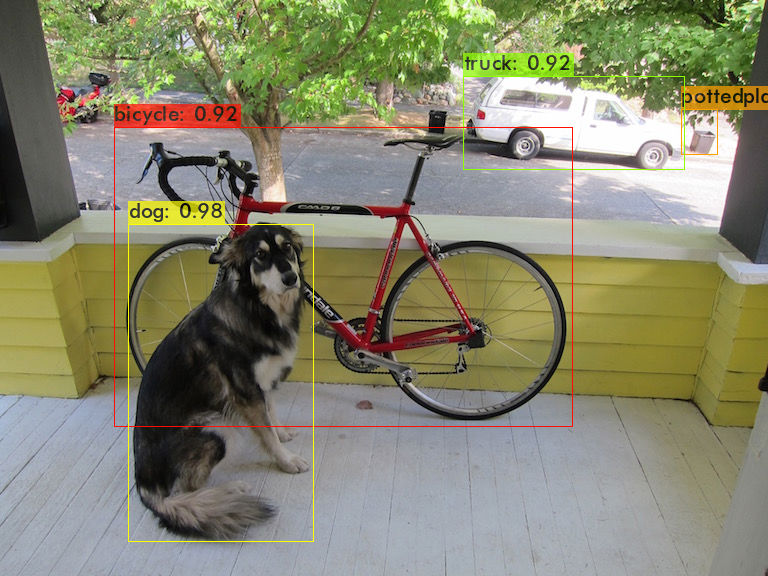

In [16]:
!ls
!./darknet detector test cfg/coco.data cfg/yolov4.cfg /my_drive/yolov4/yolov4.weights  data/dog.jpg

import cv2 # 導入OpenCV函式庫
from google.colab.patches import cv2_imshow # 導入Colab.patches函式庫

imgResult = cv2.imread('predictions.jpg') # 讀入結果影像
cv2_imshow(imgResult) # 顯示結果影像

#8. 準備自己的資料集
1.   使用LabelImg標注工具製作符合YOLO格式 
2.   將步驟3準備好的相關設定及預訓練檔從 Google Drive  /yolov4 路徑下複製到Colab指定路徑下，包含下列六種檔案。  
    2.1   obj.data （物件資料設定）  
    2.2   obj.names （物件類別名稱）  
    2.3   yolov4.cfg （設定模型組態）  
    2.4   train.txt （訓練內容，另含原始影像壓縮檔）  
    2.5   valid.txt （驗證內容，另含原始影像壓縮檔）  
    2.6   pre-trained.weight （預訓練權重檔 yolov4.conv.137）  


In [35]:
!pwd # 確認目前路是否為darknet
!ls /my_drive/yolov4/ # 列出Ggoogle Drive /yolov4內容

/content/darknet
my_dataset.zip	my_train.txt		       test02.jpg
my_obj.data	my_yolov4_custom.cfg	       yolov4.conv.137
my_obj.names	my_yolov4_custom_last.weights  yolov4.weights
my_test.txt	test01.jpg


In [9]:
!cp /my_drive/yolov4/my_dataset.zip ../ # 複製訓練影像資料集壓縮檔到Colab根目錄
!ls /content/ # 列出

darknet  drive	my_dataset.zip	sample_data


In [10]:
!unzip ../my_dataset.zip -d data/ # 解壓縮資料集到data路徑下
!ls data/

Archive:  ../my_dataset.zip
   creating: data/my_dataset/
  inflating: data/my_dataset/img_001.jpg  
  inflating: data/my_dataset/img_001.txt  
  inflating: data/my_dataset/img_002.jpg  
  inflating: data/my_dataset/img_002.txt  
  inflating: data/my_dataset/img_003.jpg  
  inflating: data/my_dataset/img_003.txt  
  inflating: data/my_dataset/img_004.jpg  
  inflating: data/my_dataset/img_004.txt  
  inflating: data/my_dataset/img_005.jpg  
  inflating: data/my_dataset/img_005.txt  
  inflating: data/my_dataset/img_006.jpg  
 extracting: data/my_dataset/img_006.txt  
  inflating: data/my_dataset/img_007.jpg  
  inflating: data/my_dataset/img_007.txt  
  inflating: data/my_dataset/img_008.jpg  
  inflating: data/my_dataset/img_008.txt  
  inflating: data/my_dataset/img_009.jpg  
 extracting: data/my_dataset/img_009.txt  
  inflating: data/my_dataset/img_010.jpg  
  inflating: data/my_dataset/img_010.txt  
  inflating: data/my_dataset/img_011.jpg  
 extracting: data/my_dataset/img_011.tx

In [11]:
!cp /my_drive/yolov4/my_yolov4_custom.cfg ./cfg # 複製自定義組態檔到cfg路徑下
!ls cfg/

9k.labels				    resnet50.cfg
9k.names				    resnext152-32x4d.cfg
9k.tree					    rnn.cfg
alexnet.cfg				    rnn.train.cfg
cd53paspp-gamma.cfg			    strided.cfg
cifar.cfg				    t1.test.cfg
cifar.test.cfg				    tiny.cfg
coco9k.map				    tiny-yolo.cfg
coco.data				    tiny-yolo-voc.cfg
coco.names				    tiny-yolo_xnor.cfg
combine9k.data				    vgg-16.cfg
crnn.train.cfg				    vgg-conv.cfg
csdarknet53-omega.cfg			    voc.data
cspx-p7-mish.cfg			    writing.cfg
cspx-p7-mish_hp.cfg			    yolo.2.0.cfg
cspx-p7-mish-omega.cfg			    yolo9000.cfg
csresnext50-panet-spp.cfg		    yolo.cfg
csresnext50-panet-spp-original-optimal.cfg  yolov1
darknet19_448.cfg			    yolov2.cfg
darknet19.cfg				    yolov2-tiny.cfg
darknet53_448_xnor.cfg			    yolov2-tiny-voc.cfg
darknet53.cfg				    yolov2-voc.cfg
darknet.cfg				    yolov3_5l.cfg
densenet201.cfg				    yolov3.cfg
efficientnet_b0.cfg			    yolov3.coco-giou-12.cfg
efficientnet-lite3.cfg			    yolov3-openimages.cfg
enet-coco.cfg				    yolov3-spp.cfg
e

In [12]:
!cp /my_drive/yolov4/my_obj.names ./data # 複製自定義物件名稱檔到data路徑下
!cp /my_drive/yolov4/my_obj.data ./data # 複製自定義物件資料檔到data路徑下
!cp /my_drive/yolov4/my_train.txt ./data # 複製自定義訓練檔案名稱檔到data路徑下
!cp /my_drive/yolov4/my_test.txt ./data # 複製自定義驗證檔案名稱檔到data路徑下
!ls data/

9k.tree     giraffe.jpg		      labels	    my_train.txt
coco9k.map  goal.txt		      my_dataset    openimages.names
coco.names  horses.jpg		      my_obj.data   person.jpg
dog.jpg     imagenet.labels.list      my_obj.names  scream.jpg
eagle.jpg   imagenet.shortnames.list  my_test.txt   voc.names


In [13]:
!cp /my_drive/yolov4/yolov4.conv.137 ./ # 從Google Drive中複製預訓練檔到darknet根目錄
!ls ./

3rdparty	DarknetConfig.cmake.in	json_mjpeg_streams.sh  results
backup		darknet_images.py	LICENSE		       scripts
build		darknet.py		Makefile	       src
build.ps1	darknet_video.py	net_cam_v3.sh	       vcpkg.json
cfg		data			net_cam_v4.sh	       video_yolov3.sh
cmake		image_yolov3.sh		obj		       video_yolov4.sh
CMakeLists.txt	image_yolov4.sh		predictions.jpg        yolov4.conv.137
darknet		include			README.md


#9.1 正常執行訓練  
指定.data, .cfg, 預訓練參數檔，每1000次會自動備份參數到my_obj.data中backup指定路徑下。 

In [ ]:
!./darknet detector train data/my_obj.data cfg/my_yolov4_custom.cfg yolov4.conv.137 -dont_show

串流輸出內容已截斷至最後 5000 行。
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 150 Avg (IOU: 0.759779), count: 10, class_loss = 0.809760, iou_loss = 2.037031, total_loss = 2.846791 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 161 Avg (IOU: 0.661878), count: 6, class_loss = 0.206294, iou_loss = 0.152759, total_loss = 0.359053 
 total_bbox = 1059795, rewritten_bbox = 0.001038 % 

 999: 1.600551, 1.900751 avg loss, 0.000996 rate, 2.564639 seconds, 63936 images, 5.818678 hours left
Loaded: 0.000047 seconds
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 139 Avg (IOU: 0.726031), count: 25, class_loss = 4.240381, iou_loss = 18.100405, total_loss = 22.340786 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 150 Avg (IOU: 0.720767), count: 58, class_loss = 3.600100, iou_loss = 11.066990, total_loss = 14.667089 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 161 Avg (IOU: 0.663618), count: 17, class_loss = 

#9.2 重新接續執行訓練  
如果不小心中斷，可從Google Drive中把最後一次權重檔 my_yolov4_custom_last.weights 複製到Colab /darknet/backup下  
再重新啟動訓練

In [17]:
!cp /my_drive/yolov4/my_yolov4_custom_last.weights backup/
!ls backup/

my_yolov4_custom_last.weights


In [14]:
!./darknet detector train data/my_obj.data cfg/my_yolov4_custom.cfg backup/my_yolov4_custom_last.weights -dont_show

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
my_yolov4_custom
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 4, batch = 64, time_steps = 1, train = 1 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   3 route  1 		                           ->  208 x 208 x  64 
   4 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.

#10. 測試訓練結果 
如果訓練完成則使用my_yolov4_custom_final.weights進行推論  
若未完成則使用my_yolov4_custom_last.weight進行推論  

 CUDA-version: 11000 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   3 route  1 		                           ->  208 x 208 x  64 
   4 conv     64       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  64 0.354 BF
   5 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   6 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   8 conv 

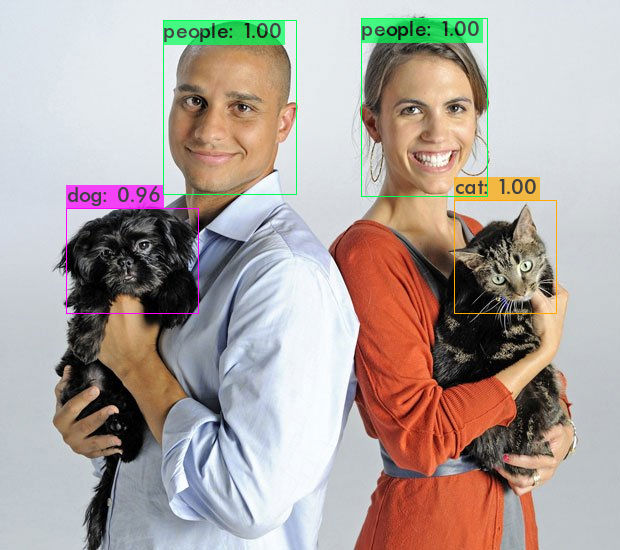

In [36]:
!./darknet detector test data/my_obj.data cfg/my_yolov4_custom.cfg backup/my_yolov4_custom_last.weights /my_drive/yolov4/test02.jpg

import cv2 # 導入OpenCV函式庫
from google.colab.patches import cv2_imshow # 導入Colab.patches函式庫

imgResult = cv2.imread('predictions.jpg') # 讀入結果影像
cv2_imshow(imgResult) # 顯示結果影像